# Clustering with Features Selection

In [3]:
!pip install skfeature-chappers

In [1]:
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

from sklearn.metrics import silhouette_score
from kneed import KneeLocator

from scipy.interpolate import make_interp_spline, BSpline

from sklearn.decomposition import PCA

import math
import statistics

from sklearn.feature_selection import SelectKBest

from skfeature.utility import construct_W  # for affinity matrix for Laplacian representation

## Reading data

In [2]:
with open ("gmw_intersection.json", "r", encoding = "utf-8") as infile:
    gmw_intersection = json.load(infile)

In [3]:
with open("ns_subreddit_2021-01.json", "r", encoding = "utf-8") as infile1:
    ns_subreddit_jan = json.load(infile1)

with open("ns_subreddit_2021-02.json", "r", encoding = "utf-8") as infile2:
    ns_subreddit_feb = json.load(infile2)
    
with open("ns_subreddit_2021-03.json", "r", encoding = "utf-8") as infile3:
    ns_subreddit_march = json.load(infile3)

with open("ns_subreddit_2021-04.json", "r", encoding = "utf-8") as infile4:
    ns_subreddit_april = json.load(infile4)
    
with open("ns_subreddit_2021-05.json", "r", encoding = "utf-8") as infile5:
    ns_subreddit_may = json.load(infile5)
    
with open("ns_subreddit_2021-02.json", "r", encoding = "utf-8") as infile6:
    ns_subreddit_jun = json.load(infile6)

In [4]:
# Reading in all the subreddits in our files

with open("subreddit_ns_2021-01.json", "r", encoding = "utf-8") as infile1a:
    subreddit_ns_jan = json.load(infile1a)

with open("subreddit_ns_2021-02.json", "r", encoding = "utf-8") as infile2a:
    subreddit_ns_feb = json.load(infile2a)
    
with open("subreddit_ns_2021-03.json", "r", encoding = "utf-8") as infile3a:
    subreddit_ns_march = json.load(infile3a)
    
with open("subreddit_ns_2021-04.json", "r", encoding = "utf-8") as infile4a:
    subreddit_ns_april = json.load(infile4a)
    
with open("subreddit_ns_2021-05.json", "r", encoding = "utf-8") as infile5a:
    subreddit_ns_may = json.load(infile5a)
    
with open("subreddit_ns_2021-02.json", "r", encoding = "utf-8") as infile6a:
    subreddit_ns_jun = json.load(infile6a)

Now, let's set up a fixed ordering for the subreddits as features

In [5]:
subreddit_intersection = list(set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

In [6]:
len(subreddit_intersection)

6220

Let's create the vector representations for each news source, only for news sources that appear in all 6 months.

In [7]:
news_sources_intersection = list(set(ns_subreddit_jan) & set(ns_subreddit_feb) &
      set(ns_subreddit_march) & set(ns_subreddit_april) &
      set(ns_subreddit_may) & set(ns_subreddit_jun))

In [8]:
ns_sr_rep = dict()
for ns in news_sources_intersection: #ns_subreddit_april:
    # the representation of a news source = # mentions in each subreddit
    ns_subreddit_april[ns] = Counter(ns_subreddit_april[ns])
    # making sure the ordering follows `subreddit_intersection`
    ns_sr_rep[ns] = [ns_subreddit_april[ns][subreddit_intersection[idx]] for idx in range(len(subreddit_intersection))]

# added Dec 12

# january
for ns_jan in ns_subreddit_jan:
    ns_subreddit_jan[ns_jan] = Counter(ns_subreddit_jan[ns_jan])
    if ns_jan in ns_sr_rep:
        # update
        ns_sr_rep[ns_jan] = [ns_sr_rep[ns_jan][idx] + ns_subreddit_jan[ns_jan][subreddit_intersection[idx]] 
                             for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_jan] = [ns_subreddit_jan[ns_jan][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

# february
for ns_feb in ns_subreddit_feb:
    ns_subreddit_feb[ns_feb] = Counter(ns_subreddit_feb[ns_feb])
    if ns_feb in ns_sr_rep:
        ns_sr_rep[ns_feb] = [ns_sr_rep[ns_feb][idx] + ns_subreddit_feb[ns_feb][subreddit_intersection[idx]] 
                             for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_feb] = [ns_subreddit_feb[ns_feb][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

# march
for ns_march in ns_subreddit_march:
    ns_subreddit_march[ns_march] = Counter(ns_subreddit_march[ns_march])
    if ns_march in ns_sr_rep:
        ns_sr_rep[ns_march] = [ns_sr_rep[ns_march][idx] + ns_subreddit_march[ns_march][subreddit_intersection[idx]] 
                               for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_march] = [ns_subreddit_march[ns_march][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]
     

    
# may
for ns_may in ns_subreddit_may:
    ns_subreddit_may[ns_may] = Counter(ns_subreddit_may[ns_may])
    if ns_may in ns_sr_rep:
        ns_sr_rep[ns_may] = [ns_sr_rep[ns_may][idx] + ns_subreddit_may[ns_may][subreddit_intersection[idx]] 
                             for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_may] = [ns_subreddit_may[ns_may][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]
        
# june
for ns_jun in ns_subreddit_jun:
    ns_subreddit_jun[ns_jun] = Counter(ns_subreddit_jun[ns_jun])
    if ns_jun in ns_sr_rep:
        ns_sr_rep[ns_jun] = [ns_sr_rep[ns_jun][idx] + ns_subreddit_jun[ns_jun][subreddit_intersection[idx]] 
                             for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_jun] = [ns_subreddit_jun[ns_jun][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

Now we normalize the news sources' representations using `numpy`'s normalize.

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit_transform(np.array([[0,20,1000]]).T).T[0]

array([0.  , 0.02, 1.  ])

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit_transform(np.array([[0,20,1000],[1,50,5]]))

array([[0., 0., 1.],
       [1., 1., 0.]])

(Horizontal Normalization)

In [11]:
# ns_sr_rep_normalized = dict()

# for ns in ns_sr_rep:
#     rep = ns_sr_rep[ns]
#     # ns_sr_rep_normalized[ns] = preprocessing.normalize(np.array([rep]))
#     min_max_scaler = preprocessing.MinMaxScaler()
#     ns_sr_rep_normalized[ns] = min_max_scaler.fit_transform(np.array([rep]).T).T[0]

ns_sr_rep_normalized = ns_sr_rep

In [12]:
len(ns_sr_rep_normalized)

2785

We have 2785 news sources.

In [13]:
list(ns_sr_rep_normalized.items())[0]

('truthdig.com',
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [14]:
"nytimes.com" in ns_sr_rep_normalized.keys()

True

### Features Selection

First I cast the data structure I needed to te appropriate based on the functions I will call.

In [15]:
frozen_nsfeatures = list(ns_sr_rep_normalized.items())

In [16]:
newssources = [k[0] for k in frozen_nsfeatures]

In [17]:
len(newssources)

2785

In [18]:
features = [k[1] for k in frozen_nsfeatures]

In [19]:
len(features)

2785

In [20]:
features[:3]

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


#### Normalizing
Vertical normalization.

In [21]:
min_max_scaler = preprocessing.MinMaxScaler()
# features_normalized = min_max_scaler.fit_transform(features)
features_normalized = preprocessing.normalize(features)
# features_normalized = preprocessing.normalize(features,axis=0)

# features_normalized = features

In [22]:
?preprocessing.normalize

In [23]:
preprocessing.normalize([[1000,1,5,10],[990,2,500,1200],[985,10,50,35],[995,1450,20,20]], axis=0)

array([[5.03770347e-01, 6.89637952e-04, 9.94200838e-03, 8.32834649e-03],
       [4.98732643e-01, 1.37927590e-03, 9.94200838e-01, 9.99401579e-01],
       [4.96213792e-01, 6.89637952e-03, 9.94200838e-02, 2.91492127e-02],
       [5.01251495e-01, 9.99975031e-01, 3.97680335e-02, 1.66566930e-02]])

Then we select 500 features. Note that we need unsupervised feature selection method. Continue here: https://towardsdatascience.com/overview-of-feature-selection-methods-a2d115c7a8f7.

In [24]:
?construct_W.construct_W

In [25]:
# creating Laplacian matrix representation
# from skfeature.utility import construct_W

kwargs_W = {"metric":"euclidean","neighbor_mode":"knn","weight_mode":"heat_kernel","k":5,'t':1}

# kwargs_W = {"metric":"cosine","neighbor_mode":"knn","weight_mode":"cosine"} #,"k":5,'t':1}
W = construct_W.construct_W(np.array(features_normalized), **kwargs_W)

In [26]:
# ranking scores
from skfeature.function.similarity_based import lap_score

score = lap_score.lap_score(np.array(features_normalized), W=W, mode="rank")

In [27]:
print(score)

[6075 5127 3045 ...  775 1859  293]


In [28]:
len(set(score)) == len(score) # subreddits were assigned unique scores

True

In [29]:
len(score) == len(subreddit_intersection)

True

Let's order our subreddits based on their importance in this sense.

In [30]:
# ordered_subreddits_dict = {sc:subreddit_intersection[sc] for sc in score}
ordered_subreddits_dict = {score[idx]:subreddit_intersection[idx] for idx in range(len(score))}

In [31]:
ordered_subreddits = [ordered_subreddits_dict[s] for s in range(len(score))]

In [32]:
for i in range(50):
    print(f"ordered_subreddits[{i}]: {ordered_subreddits[i]}")

ordered_subreddits[0]: ScienceUncensored
ordered_subreddits[1]: worldpolitics
ordered_subreddits[2]: Invincible
ordered_subreddits[3]: GulliversNewYork
ordered_subreddits[4]: BillBurr
ordered_subreddits[5]: HorrorMovies
ordered_subreddits[6]: OntarioUniversities
ordered_subreddits[7]: French
ordered_subreddits[8]: WTF
ordered_subreddits[9]: ContactlessCard
ordered_subreddits[10]: croatia
ordered_subreddits[11]: Mogong
ordered_subreddits[12]: Edinburgh_University
ordered_subreddits[13]: ape
ordered_subreddits[14]: LatinoPeopleTwitter
ordered_subreddits[15]: RedMeatPolitics
ordered_subreddits[16]: devops
ordered_subreddits[17]: MUAontheCheap
ordered_subreddits[18]: EnoughWumaoSpam
ordered_subreddits[19]: LiverpoolFC
ordered_subreddits[20]: nsclc
ordered_subreddits[21]: CanadaPublicServants
ordered_subreddits[22]: japanlife
ordered_subreddits[23]: wheresthebeef
ordered_subreddits[24]: laptops
ordered_subreddits[25]: ParlerWatch
ordered_subreddits[26]: missoula
ordered_subreddits[27]: XSPA

In [33]:
# Ten most important subreddits
ordered_subreddits[:50]

['ScienceUncensored',
 'worldpolitics',
 'Invincible',
 'GulliversNewYork',
 'BillBurr',
 'HorrorMovies',
 'OntarioUniversities',
 'French',
 'WTF',
 'ContactlessCard',
 'croatia',
 'Mogong',
 'Edinburgh_University',
 'ape',
 'LatinoPeopleTwitter',
 'RedMeatPolitics',
 'devops',
 'MUAontheCheap',
 'EnoughWumaoSpam',
 'LiverpoolFC',
 'nsclc',
 'CanadaPublicServants',
 'japanlife',
 'wheresthebeef',
 'laptops',
 'ParlerWatch',
 'missoula',
 'XSPA',
 'MobileOverview',
 'u_ArizonaRepublic',
 'Huawei',
 'Biohackers',
 'transhumanism',
 'IndigenousThinking',
 'PDXProtests',
 'ThisParanormalLife',
 'AntiRacisme',
 'HannibalTV',
 'ForestofBowland',
 'EuropeanMuslims',
 'Judaism',
 'newcastle',
 'tokkiefeesboek',
 'education',
 'Hedgewitch',
 'AskScienceDiscussion',
 'Watford_FC',
 'u_Onlinemarketing0',
 'u_Parkshala',
 'Groningenzakelijk']

In [34]:
# with open("ordered_subreddits_laplacian.json", "w", encoding="utf-8") as outfile:
#     json.dump(ordered_subreddits, outfile)

In [35]:
# filter to only include the 100 top subreddits
new_features_laplacian = [[row[idx] for idx in range(len(row)) if subreddit_intersection[idx] in ordered_subreddits[:200]] for row in features_normalized]

In [36]:
len(new_features_laplacian[0])

200

## Clustering

For starters, let's try 5 clusters

In [37]:
[(min(k), max(k)) for k in new_features_laplacian]

[(0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.04686610157417846),
 (0.0, 0.0038295410695542054),
 (0.0, 0.0),
 (0.0, 0.011988695494069664),
 (0.0, 0.0),
 (0.0, 0.4142242984627982),
 (0.0, 0.0),
 (0.0, 0.022639736366332933),
 (0.0, 0.023724045461035122),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.14865882924943327),
 (0.0, 0.007169978766856319),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.024655683636076897),
 (0.0, 0.0),
 (0.0, 0.022533155171890768),
 (0.0, 0.00022516477204884586),
 (0.0, 0.012722319560441259),
 (0.0, 0.032091527190284),
 (0.0, 0.0),
 (0.0, 0.0021099265147809707),
 (0.0, 0.0),
 (0.0, 0.75),
 (0.0, 0.2541164555262278),
 (0.0, 0.047036043419179864),
 (0.0, 0.04576287619562755),
 (0.0, 0.03880752628531664),
 (0.0, 0.024551430807011814),
 (0.0, 0.0),
 (0.0, 0.03344500310453256),
 (0.0, 0.022145800696175846),
 (0.0, 0.12623888061956062),
 (0.0, 0.009926933676592057),
 (0.0, 0.6548309476182295),
 (0.0, 0.4583492485141057),
 (0.0, 0.0),
 (0.0, 0.013213415189152408),
 (0.0, 0.0)

In [38]:
len([k for k in new_features_laplacian if (min(k), max(k)) == (0.0, 0.0)])/len(newssources)

0.4477558348294434

58% of the news sources only have 0's as its features. Let's discard these news sources

In [39]:
not_just_zeroes = [idx for idx in range(len(new_features_laplacian)) if (min(new_features_laplacian[idx]), max(new_features_laplacian[idx])) != (0.0, 0.0)]

In [40]:
len(not_just_zeroes)

1538

In [41]:
new_features_laplacian = [new_features_laplacian[i] for i in not_just_zeroes]

In [42]:
len(new_features_laplacian)

1538

In [43]:
newssources = [newssources[i] for i in not_just_zeroes]
len(newssources)

1538

In [44]:
kmeans5 = KMeans(init = "random",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

In [45]:
kmeans5.fit(new_features_laplacian)

KMeans(init='random', max_iter=100, n_clusters=5)

In [46]:
kmeans5.inertia_

53.35245426790632

In [47]:
kmeans5.n_iter_

9

### Choosing the appropriate number of clusters

In [48]:
# Elbow method
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 56789432
}

In [49]:
sse = []
for k in range(1,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features_laplacian)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [60.74857756125918]
have done 2 rounds, current sse is [60.74857756125918, 57.26054301151419]
have done 3 rounds, current sse is [60.74857756125918, 57.26054301151419, 53.85394862829485]
have done 4 rounds, current sse is [60.74857756125918, 57.26054301151419, 53.85394862829485, 50.13331177253343]
have done 5 rounds, current sse is [60.74857756125918, 57.26054301151419, 53.85394862829485, 50.13331177253343, 46.699289830699776]
have done 6 rounds, current sse is [60.74857756125918, 57.26054301151419, 53.85394862829485, 50.13331177253343, 46.699289830699776, 44.22173976194114]
have done 7 rounds, current sse is [60.74857756125918, 57.26054301151419, 53.85394862829485, 50.13331177253343, 46.699289830699776, 44.22173976194114, 42.819199566186015]
have done 8 rounds, current sse is [60.74857756125918, 57.26054301151419, 53.85394862829485, 50.13331177253343, 46.699289830699776, 44.22173976194114, 42.819199566186015, 41.58542782654782]
have done 9 rounds, cu

have done 28 rounds, current sse is [60.74857756125918, 57.26054301151419, 53.85394862829485, 50.13331177253343, 46.699289830699776, 44.22173976194114, 42.819199566186015, 41.58542782654782, 39.68604381971673, 38.61100665180423, 37.025190843670245, 35.32563947875656, 34.00253498985292, 33.24054124982647, 32.115839581242575, 31.311916587918763, 30.458248445868527, 30.53448396954549, 28.973318903536285, 27.538483749788682, 26.91005745657261, 26.17824490703035, 25.269861070407817, 24.407551973311833, 23.637392045712446, 22.939143611036698, 22.255738986447707, 21.871233248034653]
have done 29 rounds, current sse is [60.74857756125918, 57.26054301151419, 53.85394862829485, 50.13331177253343, 46.699289830699776, 44.22173976194114, 42.819199566186015, 41.58542782654782, 39.68604381971673, 38.61100665180423, 37.025190843670245, 35.32563947875656, 34.00253498985292, 33.24054124982647, 32.115839581242575, 31.311916587918763, 30.458248445868527, 30.53448396954549, 28.973318903536285, 27.538483749

have done 40 rounds, current sse is [60.74857756125918, 57.26054301151419, 53.85394862829485, 50.13331177253343, 46.699289830699776, 44.22173976194114, 42.819199566186015, 41.58542782654782, 39.68604381971673, 38.61100665180423, 37.025190843670245, 35.32563947875656, 34.00253498985292, 33.24054124982647, 32.115839581242575, 31.311916587918763, 30.458248445868527, 30.53448396954549, 28.973318903536285, 27.538483749788682, 26.91005745657261, 26.17824490703035, 25.269861070407817, 24.407551973311833, 23.637392045712446, 22.939143611036698, 22.255738986447707, 21.871233248034653, 21.010405111674416, 19.9157633413789, 19.72676357399243, 18.800117532664167, 18.845743336168024, 18.181775861364553, 18.107376908531467, 16.746996407850947, 16.96260693657191, 16.33274028740385, 15.8256242892741, 15.473705824343334]
have done 41 rounds, current sse is [60.74857756125918, 57.26054301151419, 53.85394862829485, 50.13331177253343, 46.699289830699776, 44.22173976194114, 42.819199566186015, 41.585427826

have done 50 rounds, current sse is [60.74857756125918, 57.26054301151419, 53.85394862829485, 50.13331177253343, 46.699289830699776, 44.22173976194114, 42.819199566186015, 41.58542782654782, 39.68604381971673, 38.61100665180423, 37.025190843670245, 35.32563947875656, 34.00253498985292, 33.24054124982647, 32.115839581242575, 31.311916587918763, 30.458248445868527, 30.53448396954549, 28.973318903536285, 27.538483749788682, 26.91005745657261, 26.17824490703035, 25.269861070407817, 24.407551973311833, 23.637392045712446, 22.939143611036698, 22.255738986447707, 21.871233248034653, 21.010405111674416, 19.9157633413789, 19.72676357399243, 18.800117532664167, 18.845743336168024, 18.181775861364553, 18.107376908531467, 16.746996407850947, 16.96260693657191, 16.33274028740385, 15.8256242892741, 15.473705824343334, 15.099817307722459, 14.983156479407388, 14.509178843486273, 13.955974679816098, 13.690212703243134, 13.273244277711566, 12.973962696584632, 12.580941477943053, 12.302580731013556, 12.1

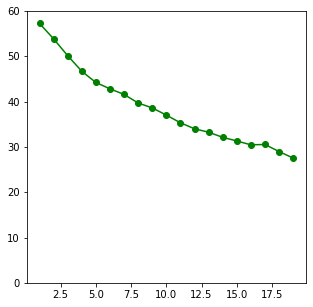

In [50]:
figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(1,20),sse[1:20],"go-")
plt.ylim([0,60])
plt.ticklabel_format(style = 'plain')

In [51]:
kl = KneeLocator(range(1,20), sse[1:20], curve="convex", direction="decreasing")
kl.elbow

11

(0.0, 60.0)

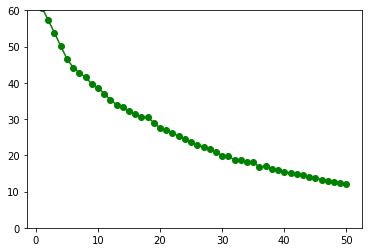

In [52]:
plt.plot(range(1,51),sse,"go-")
plt.ylim([0,60])

In [53]:
kl = KneeLocator(range(1,51), sse[:51], curve="convex", direction="decreasing")
kl.elbow

15

Using Silhouette Coefficient

In [54]:
sc = []
new_sse = []
for k in range(2,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features_laplacian)
    score = silhouette_score(new_features_laplacian, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50


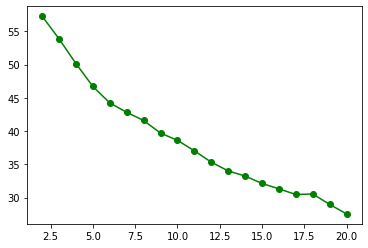

In [55]:
# for sse
plt.plot(range(2,21), new_sse[:19], "go-")

In [56]:
kl_new = KneeLocator(range(2,21), new_sse[:19], curve="convex", direction="decreasing")
kl_new.elbow

12

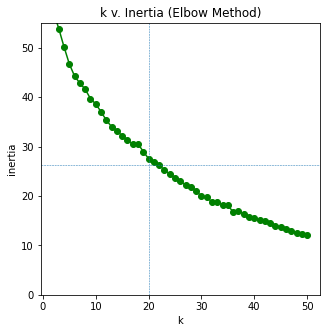

In [57]:
figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(2,51),new_sse,"go-")
plt.ylim([0,55])
plt.title("k v. Inertia (Elbow Method)")
plt.ylabel("inertia")
plt.xlabel("k")
plt.axvline(x=20, linestyle='--', linewidth = 0.5)
plt.axhline(y=new_sse[20], linestyle='--', linewidth = 0.5)

In [58]:
kl_new = KneeLocator(
    range(2,51), 
    new_sse, 
    curve="convex", 
    direction="decreasing")
kl_new.elbow

15

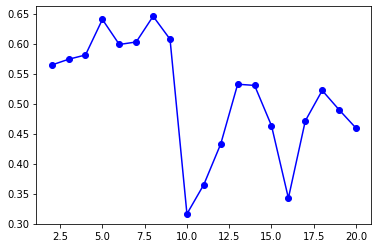

In [59]:
# for silhouette coefficient
plt.plot(range(2,21), sc[:19], "bo-")

Text(0.5, 0, 'k')

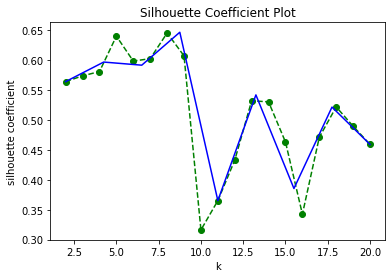

In [60]:


spl = make_interp_spline(range(2,21), sc[:19], k=3)  # type: BSpline

xs = np.linspace(2, 20, 9)
ys = spl(xs)

plt.plot(range(2,21), sc[:19], "go--")
plt.plot(xs, ys, "b-")
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

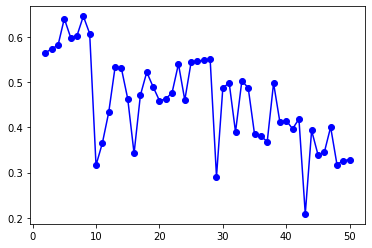

In [61]:
# for silhouette coefficient
plt.plot(range(2,51), sc, "bo-")

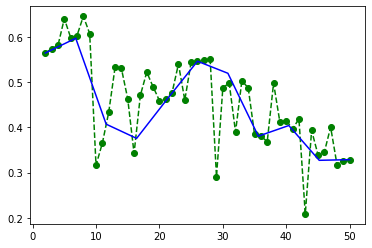

In [62]:


spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 11)
ys = spl(xs)

plt.plot(range(2,51), sc, "go--")
plt.plot(xs, ys, "b-")

In [63]:
len(sc)

49

In [64]:
print([k+2 for k in range(len(sc[2:])) if sc[k]==max(sc[2:])])

[8]


Text(0.5, 0, 'k')

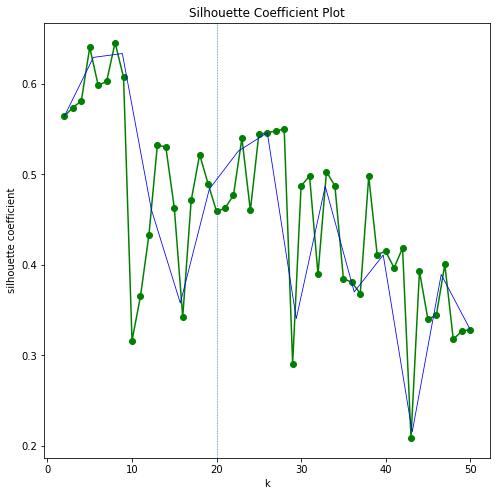

In [65]:
figure(figsize=(8, 8)) #, dpi=80)
spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 15)
ys = spl(xs)

plt.plot(range(2,51), sc, "go-")
plt.plot(xs, ys, "b-", linewidth=0.8)
plt.axvline(x=20, linestyle='--', linewidth = 0.5)
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

Clusters

In [66]:
kmeans = KMeans(n_clusters = 20, init="k-means++", n_init = 50, max_iter = 500, random_state = 56789432)
kmeans.fit(new_features_laplacian)

KMeans(max_iter=500, n_clusters=20, n_init=50, random_state=56789432)

In [67]:
clustered = defaultdict(list)
for idx,ns in enumerate(newssources):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [68]:
print(f"Cluster size (total of {len(newssources)})")
print([len(clustered[i]) for i in range(20)])

Cluster size (total of 1538)
[1345, 25, 5, 1, 6, 4, 40, 9, 4, 6, 67, 1, 2, 3, 1, 5, 1, 2, 4, 7]


In [69]:
print("Proportion in each cluster:")
print([round(len(clustered[i])*100/len(newssources),2) for i in range(12)])

Proportion in each cluster:
[87.45, 1.63, 0.33, 0.07, 0.39, 0.26, 2.6, 0.59, 0.26, 0.39, 4.36, 0.07]


In [70]:
clustered[6]

['erienewsnow.com',
 'wcax.com',
 'mynbc5.com',
 'good.is',
 'newsadvance.com',
 'k2radio.com',
 'santamariatimes.com',
 'kiwaradio.com',
 'theridgefieldpress.com',
 'khak.com',
 'capitalpress.com',
 'albanyherald.com',
 'wunc.org',
 'hamodia.com',
 'vpr.org',
 'theintelligencer.com',
 'lancasteronline.com',
 'thejewishnews.com',
 'kwqc.com',
 'njtoday.net',
 'nbc11news.com',
 'rare.us',
 'kabc.com',
 'diverseeducation.com',
 'benningtonbanner.com',
 'press-citizen.com',
 'thealpenanews.com',
 'fox10phoenix.com',
 'kiiitv.com',
 'radiomilwaukee.org',
 'tyt.com',
 'fox61.com',
 'thebrunswicknews.com',
 'democratherald.com',
 'theeastsiderla.com',
 'abc57.com',
 'mynbc15.com',
 'whas11.com',
 'athensnews.com',
 'wthitv.com']

In [71]:
print([k for k in range(25) if "foxnews.com" in clustered[k]])

[0]


In [72]:
?KMeans

## Low Variance
What about selecting features using `skfeature.function.statistical_based.low_variance`

First let's look at the various variances of the feature columns.

In [73]:
variances = [statistics.pvariance([row[idx] for row in features_normalized]) for idx in range(len(features_normalized[0]))]

In [74]:
len(variances)

6220

In [75]:
max(variances)

0.036082942854536185

Text(0.5, 0, 'variance')

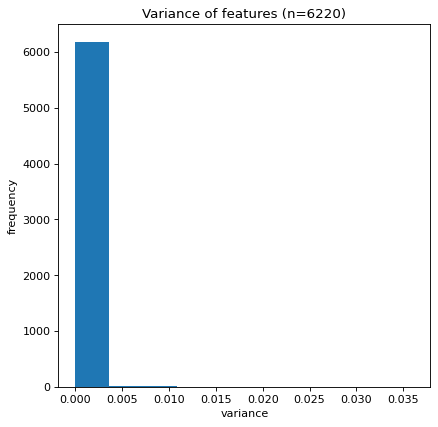

In [76]:
figure(figsize=(6, 6), dpi=80)
plt.hist([v for v in variances])
plt.title("Variance of features (n=6220)")
plt.ylabel("frequency")
plt.xlabel("variance")

In [77]:
?plt.yticks

([<matplotlib.axis.YTick at 0x13e28f31640>,
 [Text(0, 0, ''), Text(0, 1, '>0.001'), Text(0, 2, 'all')])

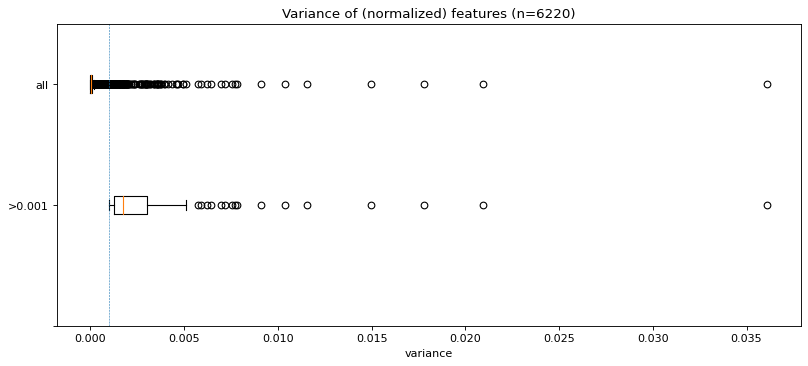

In [78]:
figure(figsize=(12, 5), dpi=80)
# plt.boxplot([v for v in variances], vert=False)
plt.boxplot([[v for v in variances if v > 0.001],[v for v in variances]], vert = False)
plt.axvline(x=0.001, linestyle='--', linewidth = 0.5)
plt.title("Variance of (normalized) features (n=6220)")
# plt.ylabel("frequency")
plt.xlabel("variance")
plt.yticks(np.arange(0, 1))  # Set label locations.
plt.yticks(np.arange(3), ['','>0.001', 'all'])  # Set text labels.
# plt.xlim([0.001,0.038])

In [79]:
from sklearn.feature_selection import VarianceThreshold

In [80]:
# threshold = 0.000075
selector = VarianceThreshold(threshold=0.0009)
new_features = selector.fit_transform(np.array(features_normalized))

In [81]:
len(new_features[0])

206

In [82]:
# ?VarianceThreshold

How many news sources had only 0's as features?

In [83]:
not_just_zeroes = [(newssources[idx], min(new_features[idx]),max(new_features[idx])) for idx in range(len(new_features)) if (min(new_features[idx]),max(new_features[idx])) != (0.0,0.0)]

IndexError: list index out of range

In [ ]:
len(not_just_zeroes)

In [ ]:
len(newssources)

## Clustering

For starters, let's try 5 clusters

In [ ]:
items = new_features.tolist()

In [ ]:
kmeans5 = KMeans(init = "random",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

In [ ]:
kmeans5.fit(new_features)

In [ ]:
kmeans5.inertia_

In [ ]:
kmeans5.n_iter_

### Choosing the appropriate number of clusters

In [ ]:
# Elbow method
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 56789432
}

In [ ]:
sse = []
for k in range(1,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

In [ ]:
plt.plot(range(1,20),sse[1:20],"go-")
plt.ylim([0,1500])

In [ ]:
kl = KneeLocator(range(1,20), sse[1:20], curve="convex", direction="decreasing")
kl.elbow

In [ ]:
figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(1,51),sse,"go-")
plt.ylim([0,1600])
plt.title("k v. Inertia (Elbow Method)")
plt.ylabel("inertia")
plt.xlabel("k")
plt.axvline(x=16, linestyle='--', linewidth = 0.5)
plt.axhline(y=sse[16], linestyle='--', linewidth = 0.5)

In [ ]:
?KneeLocator

In [ ]:
kl = KneeLocator(
        range(1,51), 
        sse, curve="convex", 
        direction="decreasing")
kl.elbow

Using Silhouette Coefficient

In [ ]:
sc = []
new_sse = []
for k in range(2,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features)
    score = silhouette_score(new_features, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

In [ ]:
# for sse
plt.plot(range(2,21), new_sse[:19], "go-")

In [ ]:
kl_new = KneeLocator(range(2,21), new_sse[:19], curve="convex", direction="decreasing")
kl_new.elbow

In [ ]:
# for silhouette coefficient
plt.plot(range(2,21), sc[:19], "bo-")

In [ ]:

figure(figsize=(5, 5)) #, dpi=80)
spl = make_interp_spline(range(2,21), sc[:19], k=3)  # type: BSpline

xs = np.linspace(2, 20, 6)
ys = spl(xs)

plt.plot(range(2,21), sc[:19], "go-")
plt.plot(xs, ys, "b--", linewidth=0.7)
plt.axvline(x=16, linestyle='--', linewidth = 0.5)
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

In [ ]:
# for silhouette coefficient
figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(2,51), sc, "bo-")

In [ ]:

figure(figsize=(5, 5)) #, dpi=80)
spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 7)
ys = spl(xs)

plt.plot(range(2,51), sc, "go--")
plt.plot(xs, ys, "b-")

In [ ]:
figure(figsize=(8, 8)) #, dpi=80)
spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 8)
ys = spl(xs)

plt.plot(range(2,51), sc, "go-")
plt.plot(xs, ys, "b-", linewidth=0.8)
plt.axvline(x=16, linestyle='--', linewidth = 0.5)
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

In [ ]:
kl = KneeLocator(
        range(3,51), 
        sc[1:], curve="concave", 
        direction="increasing")
kl.elbow

In [ ]:
len(sc)

In [ ]:
print([k for k in range(len(sc)) if sc[k]==max(sc)])

Clusters

In [ ]:
kmeans = KMeans(n_clusters = 16, init="k-means++", n_init = 50, max_iter = 500, random_state = 56789432)
kmeans.fit(new_features)

In [ ]:
clustered = defaultdict(list)
for idx,ns in enumerate(newssources):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [ ]:
print(f"Cluster size (total of {len(newssources)})")
print([len(clustered[i]) for i in range(16)])

In [ ]:
print("Proportion in each cluster:")
print([round(len(clustered[i])*100/len(newssources),2) for i in range(12)])

In [ ]:
len(newssources)-1647

In [ ]:
clustered[15]

Clusters:

0: NPR/NBC affiliated Radio & TV    4: (not sure)                  8:Lifestyle Magazines   12:Argentinian news
1: UK Sport                         5: French news                 9: Mostly (US) TV       13: Other oreign news
2: Some Canadian news (?)           6: (the big cluster)           10: Chilean news        14: German news
3: Brazilian news                   7: Big names, NBC/ABC/PBS TV   11: Italian news        15: Mexican news

In [ ]:
print([k for k in range(25) if "foxnews.com" in clustered[k]])

In [ ]:
?KMeans

## Using Subscribers

In [ ]:
# Let's only use the subreddits that have lots of subscribers
with open ("subreddit_subscribers.json", "r", encoding = "utf-8") as infile:
    subreddit_subscribers = json.load(infile)

In [ ]:
subreddits_w_subc = [subreddit_intersection[k] for k in range(len(subreddit_intersection)) if subreddit_intersection[k] in subreddit_subscribers]
len(subreddits_w_subc)

In [ ]:
len(subreddit_intersection)

Handle missing values

In [ ]:
print([s for s in subreddits_w_subc if subreddit_subscribers[s] is None])

In [ ]:
subreddits_w_subc = [s for s in subreddits_w_subc if subreddit_subscribers[s] is not None]

Now, I will sort the 5,672 subreddits based on the # of their subscribers in a descending order.

In [ ]:
srs_all = sorted(subreddits_w_subc, key= lambda x: subreddit_subscribers[x], reverse= True)

In [ ]:
len(srs_all)

In [ ]:
?math.log

In [ ]:
plt.hist([math.log(subreddit_subscribers[s],10) for s in srs_all if subreddit_subscribers[s] > 0])

# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])
# plt.yscale("log")
# plt.xscale("log")
plt.ylabel("number of subreddits")
plt.xlabel("number of subscribers (10^)")
plt.title("Subreddits Subscribers (n=5670)")
# log scale for both x and y

In [ ]:
print([(s,subreddit_subscribers[s]) for s in srs_all if subreddit_subscribers[s]>20000000])

In [ ]:
srs = srs_all[:200]

In [ ]:
"funny" in srs

Create news sources representations

In [ ]:
ns_sr_rep = dict()
for ns in news_sources_intersection: #ns_subreddit_april:
    # the representation of a news source = # mentions in each subreddit
    ns_subreddit_april[ns] = Counter(ns_subreddit_april[ns])
    # making sure the ordering follows `subreddit_intersection`
    ns_sr_rep[ns] = [ns_subreddit_april[ns][srs[idx]] for idx in range(len(srs))]

# added Dec 12

# january
for ns_jan in ns_subreddit_jan:
    ns_subreddit_jan[ns_jan] = Counter(ns_subreddit_jan[ns_jan])
    if ns_jan in ns_sr_rep:
        # update
        ns_sr_rep[ns_jan] = [ns_sr_rep[ns_jan][idx] + ns_subreddit_jan[ns_jan][srs[idx]] 
                             for idx in range(len(srs))]   
#     else:
#         ns_sr_rep[ns_jan] = [ns_subreddit_jan[ns_jan][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

# february
for ns_feb in ns_subreddit_feb:
    ns_subreddit_feb[ns_feb] = Counter(ns_subreddit_feb[ns_feb])
    if ns_feb in ns_sr_rep:
        ns_sr_rep[ns_feb] = [ns_sr_rep[ns_feb][idx] + ns_subreddit_feb[ns_feb][srs[idx]] 
                             for idx in range(len(srs))]   
#     else:
#         ns_sr_rep[ns_feb] = [ns_subreddit_feb[ns_feb][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

# march
for ns_march in ns_subreddit_march:
    ns_subreddit_march[ns_march] = Counter(ns_subreddit_march[ns_march])
    if ns_march in ns_sr_rep:
        ns_sr_rep[ns_march] = [ns_sr_rep[ns_march][idx] + ns_subreddit_march[ns_march][srs[idx]] 
                               for idx in range(len(srs))]   
#     else:
#         ns_sr_rep[ns_march] = [ns_subreddit_march[ns_march][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]
     

    
# may
for ns_may in ns_subreddit_may:
    ns_subreddit_may[ns_may] = Counter(ns_subreddit_may[ns_may])
    if ns_may in ns_sr_rep:
        ns_sr_rep[ns_may] = [ns_sr_rep[ns_may][idx] + ns_subreddit_may[ns_may][srs[idx]] 
                             for idx in range(len(srs))]   
#     else:
#         ns_sr_rep[ns_may] = [ns_subreddit_may[ns_may][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]
        
# june
for ns_jun in ns_subreddit_jun:
    ns_subreddit_jun[ns_jun] = Counter(ns_subreddit_jun[ns_jun])
    if ns_jun in ns_sr_rep:
        ns_sr_rep[ns_jun] = [ns_sr_rep[ns_jun][idx] + ns_subreddit_jun[ns_jun][srs[idx]] 
                             for idx in range(len(srs))]   
#     else:
#         ns_sr_rep[ns_jun] = [ns_subreddit_jun[ns_jun][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

In [ ]:
len(ns_sr_rep['nytimes.com'])

In [ ]:
len(ns_sr_rep)

Now we normalize the news sources' representations using `numpy`'s normalize.

(Horizontal Normalization)

In [ ]:
# ns_sr_rep_normalized = dict()

# for ns in ns_sr_rep:
#     rep = ns_sr_rep[ns]
#     # ns_sr_rep_normalized[ns] = preprocessing.normalize(np.array([rep]))
#     min_max_scaler = preprocessing.MinMaxScaler()
#     ns_sr_rep_normalized[ns] = min_max_scaler.fit_transform(np.array([rep]).T).T[0]

ns_sr_rep_normalized = ns_sr_rep

In [ ]:
len(ns_sr_rep_normalized)

We have 2785 news sources.

In [ ]:
list(ns_sr_rep_normalized.items())[0]

In [ ]:
"nytimes.com" in ns_sr_rep_normalized.keys()

In [ ]:
frozen_nsfeatures = list(ns_sr_rep_normalized.items())

In [ ]:
newssources = [k[0] for k in frozen_nsfeatures]

In [ ]:
len(newssources)

In [ ]:
features = [k[1] for k in frozen_nsfeatures]

In [ ]:
len(features)

#### Normalizing
Vertical normalization.

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
# features_normalized = min_max_scaler.fit_transform(features)
features_normalized = preprocessing.normalize(features)
# features_normalized = features

## Clustering

For starters, let's try 5 clusters

In [ ]:
kmeans5 = KMeans(init = "random",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

In [ ]:
new_features = features_normalized

In [ ]:
kmeans5.fit(new_features)

In [ ]:
kmeans5.inertia_

In [ ]:
kmeans5.n_iter_

### Choosing the appropriate number of clusters

In [ ]:
# Elbow method
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 56789432
}

In [ ]:
sse = []
for k in range(1,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

In [ ]:
plt.plot(range(1,20),sse[1:20],"go-")
plt.ylim([0,1750])

In [ ]:
kl = KneeLocator(range(1,20), sse[1:20], curve="convex", direction="decreasing")
kl.elbow

In [ ]:
figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(1,51),sse,"go-")
plt.ylim([0,1800])
plt.title("k v. Inertia (Elbow Method)")
plt.ylabel("inertia")
plt.xlabel("k")
plt.axvline(x=12, linestyle='--', linewidth = 0.5)
plt.axhline(y=sse[12], linestyle='--', linewidth = 0.5)

In [ ]:
?KneeLocator

In [ ]:
kl = KneeLocator(
        range(1,51), 
        sse, curve="convex", 
        direction="decreasing")
kl.elbow

Using Silhouette Coefficient

In [ ]:
sc = []
new_sse = []
for k in range(2,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features)
    score = silhouette_score(new_features, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

In [ ]:
# for sse
plt.plot(range(2,21), new_sse[:19], "go-")

In [ ]:
kl_new = KneeLocator(range(2,21), new_sse[:19], curve="convex", direction="decreasing")
kl_new.elbow

In [ ]:
# for silhouette coefficient
plt.plot(range(2,21), sc[:19], "bo-")

In [ ]:

figure(figsize=(5, 5)) #, dpi=80)
spl = make_interp_spline(range(2,21), sc[:19], k=3)  # type: BSpline

xs = np.linspace(2, 20, 6)
ys = spl(xs)

plt.plot(range(2,21), sc[:19], "go-")
plt.plot(xs, ys, "b--", linewidth=0.7)
plt.axvline(x=12, linestyle='--', linewidth = 0.5)
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

In [ ]:
# for silhouette coefficient
figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(2,51), sc, "bo-")

In [ ]:

figure(figsize=(5, 5)) #, dpi=80)
spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 7)
ys = spl(xs)

plt.plot(range(2,51), sc, "go--")
plt.plot(xs, ys, "b-")

In [ ]:
figure(figsize=(8, 8)) #, dpi=80)
spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 8)
ys = spl(xs)

plt.plot(range(2,51), sc, "go-")
plt.plot(xs, ys, "b-", linewidth=0.8)
plt.axvline(x=12, linestyle='--', linewidth = 0.5)
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

In [ ]:
kl = KneeLocator(
        range(3,51), 
        sc[1:], curve="concave", 
        direction="increasing")
kl.elbow

In [ ]:
len(sc)

In [ ]:
print([k for k in range(len(sc)) if sc[k]==max(sc)])

Clusters

In [ ]:
kmeans = KMeans(n_clusters = 12, init="k-means++", n_init = 50, max_iter = 500, random_state = 56789432)
kmeans.fit(new_features)

In [ ]:
clustered = defaultdict(list)
for idx,ns in enumerate(newssources):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [ ]:
print(f"Cluster size (total of {len(newssources)})")
print([len(clustered[i]) for i in range(12)])
print(f"sum: {sum([len(clustered[i]) for i in range(12)])}")

In [ ]:
print("Proportion in each cluster:")
print([round(len(clustered[i])*100/len(newssources),2) for i in range(12)])
print(f"sum: {sum([round(len(clustered[i])*100/len(newssources),2) for i in range(12)])}")

In [ ]:
len(newssources)-1647

In [ ]:
clustered[3]

Clusters:

0: NPR/NBC affiliated Radio & TV    4: (not sure)                  8:Lifestyle Magazines   12:Argentinian news
1: UK Sport                         5: French news                 9: Mostly (US) TV       13: Other oreign news
2: Some Canadian news (?)           6: (the big cluster)           10: Chilean news        14: German news
3: Brazilian news                   7: Big names, NBC/ABC/PBS TV   11: Italian news        15: Mexican news

In [ ]:
print([k for k in range(25) if "foxnews.com" in clustered[k]])

In [ ]:
clustered_new = dict()
for ii in range(12):
    clustered_new[ii] = clustered[ii]

In [ ]:
with open("clusters_subscribers.json", "w", encoding = "utf-8") as outfile:
    json.dump(clustered_new, outfile, indent = 4)